In [1]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import random
import time

In [2]:
#User input for algorithm:
#for synthetic data/potentially for regular datasets user can set the total subgroups/centroids
centroids = input("Enter number of centroids: ")
groupNum = input("Enter number of groups: ")

Enter number of centroids: 10
Enter number of groups: 5


In [3]:
#calculates euclidean distance between points
def calc_dist(x,y,x_ref,y_ref):
  return np.sqrt((((x-x_ref)**2)+((y-y_ref)**2))) 

In [4]:
#calculuates loss by putting euclidean distance of point->centroid into sigmoid function
def calc_loss(x,y,x_ref,y_ref):
    # calculate euclidean distance btw person & centroid
    distance = calc_dist(x,y,x_ref,y_ref)
    # refer to the above distance function to determine individual loss
    loss = 1/(1+ np.exp(-1*(distance))) #converts distances to probability distribution
    #return loss
    return loss

In [5]:
#this function calculates the summation of all the individual losses within each cluster for minimizing the objective function
def sum_loss(df, centroids, subgroup_loss):
  #total datapoints
  tot_len = 0
  #sum of all individual losses between clusters
  loss_sum = 0
  clusters = []
  max_val = df['min_loss'].max()
  min_val = df['min_loss'].min()
  for i in centroids.keys():
    temp = df[df['min_centr']==i]
    temp = temp.reset_index()
    clusters.append(temp)
    tot_len += len(temp)
    loss_sum += temp['min_loss'].sum()
  #weighting scheme for 2-part cost function (sum of individual losses and subgroup loss)
  tot_loss = .65*(loss_sum/tot_len)
  tot_loss += ((1-.35)*subgroup_loss)
  print(subgroup_loss)
  print('total: ', tot_loss)
  return tot_loss


In [8]:
def assign_cluster(df, centroids):
  start = time.time()
  for i in centroids.keys():
    #loss based on euclidean distance for each individual point compared to both centroids
    #stored in dataframe
    df['loss_from_{}'.format(i)] = calc_loss(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
    df['dist_from_{}'.format(i)] = calc_dist(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
  centroid_dist_col = ['loss_from_{}'.format(i) for i in centroids.keys()]
  #df column which holds the value of the closest centroid for each point
  df['min_centr'] = df.loc[:, centroid_dist_col].idxmin(axis=1)
  df['min_centr'] = df['min_centr'].map(lambda x: int(x.lstrip('loss_from_')))
  #value of loss calculated from sigmoid in calc_loss function for individual loss
  df['min_loss'] = df[['loss_from_{}'.format(i) for i in centroids.keys()]].min(axis=1)
  end = time.time()
  print('Time elapsed Assignment Step: ', end - start)
  # for i in range(len(centroids)):
  #   del df['loss_from_{}'.format(i)]
  #   lst = df['min_centr'].unique()
  #   if i not in lst:
  #     del df['dist_from_{}'.format(i)]
  return df

In [9]:
# this function compares the loss between two groups at a certain percentile level
def compare_loss(group1,group2,percentile):
    select_group = [group1, group2]
    percentile_loss = []
    for s in select_group:
        s.sort_values(by=['min_loss'])
        subgroup = [s['min_loss']] # subset the two different groups of interest
        loss_p = stats.scoreatpercentile(subgroup, percentile) # find the level of loss at given percentile
        percentile_loss.append(loss_p) # load list with loss    
    difference = percentile_loss[0]-percentile_loss[1] # find difference between two @ percentile
    return np.abs(difference)

In [56]:
#calculates gradient for clusters
def update_weights(clust, lr, centr, df):
  #total number of points in cluster 0 (points nearest to centroid 0)
  new_centr_x, new_centr_y = centr[0], centr[1]
  #calculate partial derivatives of euclidean distance functions
  x = clust['x_coord']
  y = clust['y_coord']
  center = clust['min_centr']
  distance = clust['dist_from_{}'.format(int(center))]
  grad_x = (np.exp(-1*distance) * (centr[0]-x)) / (1 + np.exp(-1*distance)*distance)
  grad_y = (np.exp(-1*distance) * (centr[1]-y)) / (1 + np.exp(-1*distance)*distance)

  return (grad_x, grad_y)

In [11]:
def softmax(x):
  return np.exp(x) / np.sum(np.exp(x), axis=0)

In [57]:
import random
def mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1,cdf2):
  #weighted mini-batch sampling
  samples = []
  group_loss = []
  for group in groups:
    group_loss.append(group['min_loss'].sum()/len(group))
  weights = softmax(group_loss)
  print('weights: ', weights)
  for i, group in enumerate(groups):
    samples.append(group.sample(n=int(b*weights[i]), random_state=1))
  samp = pd.concat([samp for samp in samples], ignore_index=True, sort=False)
  samp = samp.reset_index()
  #initializations
  sum_x = {}
  for i in centroids.keys():
    sum_x[i] = 0
  sum_y = {}
  for i in centroids.keys():
    sum_y[i] = 0
  for i in centroids.keys():
    count[i] = 0
  start = time.time()
  #update centroid locations using gradient descent
  for s in range(len(samp)):
    clust = samp.iloc[s]['min_centr']
    clust = int(clust)
    count[clust]+=1
    lr = 1/count[clust]
    temp = update_weights(samp.iloc[s], lr, temp_centroids[clust], df)
    sum_x[clust] += temp[0]
    sum_y[clust] += temp[1]
  for i in range(len(temp_centroids)):
    if count[i]!= 0:
      temp_centroids[i] = (temp_centroids[i][0]-lr*(sum_x[i]/count[i]), temp_centroids[i][1]-lr*(sum_y[i]/count[i]))
  end = time.time()
  print('Time elapsed Batch Step: ', end - start)
  return temp_centroids

In [29]:
# import random
# def mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1,cdf2):
#   #weighted mini-batch sampling
#   samples = []
#   group_loss = []
#   for group in groups:
#     group_loss.append(group['min_loss'].sum()/len(group))
#   weights = softmax(group_loss)
#   print('weights: ', weights)
#   for i, group in enumerate(groups):
#     samples.append(group.sample(n=int(b*weights[i]), random_state=1))
#   samp = pd.concat([samp for samp in samples], ignore_index=True, sort=False)
#   samp = samp.reset_index()
#   for i in range(len(samples)):
#     #initializations
#     sum_x = {}
#     for i in centroids.keys():
#       sum_x[i] = 0
#     sum_y = {}
#     for i in centroids.keys():
#       sum_y[i] = 0
#     for i in centroids.keys():
#       count[i] = 0
#     start = time.time()
#     #update centroid locations using gradient descent
#     for s in range(len(samples[i])):
#       clust = samples[i].iloc[s]['min_centr']
#       clust = int(clust)
#       count[clust]+=1
#       lr = 1/count[clust]
#       temp = update_weights(samples[i].iloc[s], lr, temp_centroids[clust], df)
#       print('TEMP ', temp)
#       sum_x[clust] += temp[0]
#       sum_y[clust] += temp[1]
#     for i in range(len(temp_centroids)):
#       if count[i]!= 0:
#         temp_centroids[i] = (temp_centroids[i][0]-lr*(sum_x[i]/count[i]), temp_centroids[i][1]-lr*(sum_y[i]/count[i]))
#     end = time.time()
#     print('Time elapsed Batch Step: ', end - start)
#   return temp_centroids

In [32]:
mini_batch(df, 1000, count, temp_centroids, centroids, groups, cdf1, cdf2)

NameError: ignored

In [44]:
#updates centroid locations based on gradient descent and loss constraint
def update(centroids, df, subgroup_loss, loss, groups, cdf1, cdf2):
  #initializations
  tot_loss_lst = []
  prev_centr = {}
  for i in centroids.keys():
    prev_centr[i] = 0
  b = 32
  max_iter = 150
  iter_num = 0
  conv = 10
  j = 0
  tot_loss_lst.append(loss)
  #set temporary centroids for assignment
  temp_centroids = {}
  for i in centroids.keys():
    temp_centroids[i] = centroids[i]
  count = {}
  #beginning of updating 
  while iter_num < max_iter:
    start = time.time()
    old_loss = loss
    #set up for mini batch gradient descent
    temp_centroids = mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1, cdf2)
    #testing to see if new centroid locations improve summation of individual loss
    temp_df = assign_cluster(df, temp_centroids)
    groups = compute_groups(temp_df)
    cdf1, cdf2 = compute_cdf(groups)
    temp_subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)   
    temp_loss = sum_loss(temp_df, temp_centroids, temp_subgroup_loss)
    iter_num += 1
    if old_loss != temp_loss and j < conv:
      #only change centroid locations if it improves subgroup loss
      if old_loss > temp_loss:
        subgroup_loss = temp_subgroup_loss
        loss = temp_loss
        df = temp_df
        groups = compute_groups(df)
        compute_cdf_graph(groups)
        for i in prev_centr.keys():
          prev_centr[i] = centroids[i]
        for i in centroids.keys():
          centroids[i] = temp_centroids[i]
        print('c ', centroids)
        j = 0
      else:
        j += 1
      # loss = sum_loss(temp_df, centroids, subgroup_loss)
      tot_loss_lst.append(loss)
    else:
      end = time.time()
      print('Time elapsed End of Update Step: ', end - start)
      #plot overall cost 
      plt.title('Cost per iteration')
      plt.plot(tot_loss_lst)
      plt.show()
      return centroids
  #plot overall cost
  plt.title('Cost per iteration')
  plt.plot(tot_loss_lst)
  plt.show()
  print('Reached max iterations')
  print('prev centroids: ', prev_centr)
  return centroids    

In [14]:
def compute_cdf(groups):
  lst = []
  perc = []
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    lst.append(sorted_data['min_loss'].sum())
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    perc.append(stats.scoreatpercentile(subgroup, 50))
  min_ind = perc.index(min(perc))
  max_ind = perc.index(max(perc))
  return (max_ind, min_ind)

In [15]:
def compute_cdf_graph(groups):
  #this function creates the cdf graph of all subgroups
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    plt.plot(sorted_data['min_loss'], yvals)
  plt.xlabel('loss per individual')
  plt.ylabel('% of people within certain loss of centroid')
  plt.title('Individual loss- CDF stratified by group')
  plt.show()

In [16]:
def compute_groups(df):
  #divides the dataframe by subgroup membership
  num_groups = df.group.nunique()
  groups = []
  for i in range(num_groups):
    group = df[df['group']==i]
    group = group.reset_index()
    groups.append(group)
  return groups

In [17]:
def compute_clusters(df):
  #divides dataframe by centroid membership
  num_clusters = df.min_centr.nunique()
  clusters = []
  for i in range(num_clusters):
    cluster = df[df['min_centr']==i]
    cluster = cluster.reset_index()
    clusters.append(cluster)
  return clusters

In [71]:
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++', n_clusters=10, random_state=0).fit(X)
centr =  kmeans.cluster_centers_
df['min_centr_old'] = kmeans.labels_

In [24]:
prev

[[-1.0311916906517329, -2.23307475336729],
 [-10.126482483156337, 7.247998595662626],
 [6.0993674405823, 8.027436973254803],
 [10.109539427897126, -2.6993939436323604],
 [-9.149655503850738, -8.856960630035625],
 [-2.011158652561878, 7.726595031227508],
 [5.142346641912587, 1.107982074727504],
 [-2.202067094462496, 2.6740376584101035],
 [1.736602121539918, 4.766821454249579],
 [1.986222312974125, 9.1115487286583]]

In [27]:


kmeans.cluster_centers_

array([[ 2.05415288,  0.89807141],
       [-9.59593401,  6.65303778],
       [ 5.56348829,  7.3999223 ],
       [ 9.27367629, -2.33131309],
       [-8.57895561, -8.25736306],
       [-1.24810198,  7.8363102 ],
       [ 5.83425772,  0.57756706],
       [-1.52664091,  2.91940551],
       [ 0.97692597,  4.30512443],
       [ 1.36098535,  8.51122628]])

Time elapsed Assignment Step:  0.018049955368041992


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  This is separate from the ipykernel package so we can avoid doing imports until


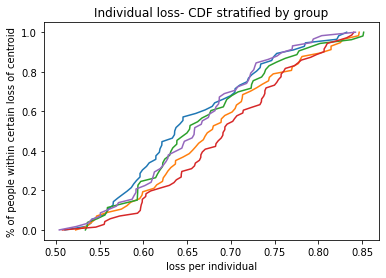

0.05624488630030278
total:  0.4731152719176913
subgroup  0.05624488630030278
tot  0.4731152719176913


In [73]:
from sklearn.cluster import KMeans
def KMeans_orig(df, data, centr):
  kmeans = KMeans(init=centr, n_clusters=4, random_state=0).fit(data)
  centr =  kmeans.cluster_centers_
  centroids = {}
  for i in range(len(centr)):
    centroids[i] = centr[i]
  df = assign_cluster(df, centroids)
  df['min_centr'] = kmeans.labels_
  df['min_loss'] = df[['loss_from_{}'.format(i) for i in centroids.keys()]].min(axis=1)
  groups = compute_groups(df)
  compute_cdf_graph(groups)
  clusters = compute_clusters(df)
  cdf1, cdf2 = compute_cdf(groups)
  #subgroup loss between max and min loss
  subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)
  loss = sum_loss(df, centroids, subgroup_loss)
  return (subgroup_loss, loss, kmeans)
subgroup, tot, kmeans = KMeans_orig(df, X, np.array(prev))
print('subgroup ', subgroup)
print('tot ', tot)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Time elapsed Assignment Step:  0.016110897064208984


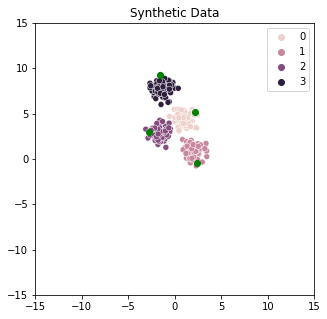

{0: (2.4304063920491905, -0.43637823139671905),
 1: (-1.549945795131673, 9.282932223367844),
 2: (-2.7836658559455922, 2.9921154098732266),
 3: (2.130035294434726, 5.1920962023090445)}

In [68]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
import random
import sys
from operator import itemgetter

# Generate Imbalanced Synthetic Data
center_box = (0,20)
# X,y = make_classification(n_samples=800000, n_classes=int(groupNum),shift=15 ,n_informative=4, n_redundant=0,n_repeated=0, n_clusters_per_class=2,class_sep=.8,flip_y=0,weights=[0.65,.15, .12, .08], random_state=55)
X, y = make_blobs(n_samples=300, centers=int(centroids), cluster_std=.6,random_state=0)
# X, y = make_blobs(n_samples=1000000, centers=int(groups), n_features=2,center_box=center_box,random_state=0)
# create dataframe to hold x and y coordinates
df = pd.DataFrame({
    'x_coord': X[:,0],
    'y_coord': X[:,1]})

numList = [i for i in range(int(groupNum))]
df['group'] = np.random.randint(0,5, df.shape[0])

 
#arbitrarily picked random k (number of centroids)
k = int(centroids)
centroids = {}
#randomly initialized centroid x and y coordinates (in real data we will actually have these coordinates)
centroids[0] = ((random.choice(X[:,0])), (random.choice(X[:,1])))
       
#K-Means++ 
for c in range(k - 1): 
  ## initialize a list to store distances of data 
  ## points from nearest centroid 
  dist = [] 
  for i in range(df.shape[0]): 
    point = (df['x_coord'][i],df['y_coord'][i])  
    d = sys.maxsize 
                                                                      
    ## compute distance of 'point' from each of the previously 
    ## selected centroid and store the minimum distance 
    for j in range(len(centroids)): 
      temp_dist = calc_dist(point[0], point[1], centroids[j][0], centroids[j][1]) 
      d = min(d, temp_dist) 
    dist.append(d) 
              
  ## select data point with maximum distance as our next centroid 
  dist = np.array(dist) 
  next_centroid = (df['x_coord'][np.argmax(dist)], df['y_coord'][np.argmax(dist)]) 
  centroids[c+1] = (next_centroid) 
  dist = [] 

#colors for centroids
color_map = {}
for i in range(k):
  color_map[i] = 'g'

#plot synthetic data
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(X[:,0],X[:,1],hue=y)
for i in centroids.keys():
  plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])
df = assign_cluster(df, centroids)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
ax.set_title("Synthetic Data")
plt.show()

centroids

In [67]:
centroids=4

In [69]:
prev = []

for i in range(len(centroids)):
  prev.append(list(centroids[i]))

In [47]:
df

,x_coord,y_coord,group,loss_from_0,dist_from_0,loss_from_1,dist_from_1,loss_from_2,dist_from_2,loss_from_3,dist_from_3,loss_from_4,dist_from_4,loss_from_5,dist_from_5,loss_from_6,dist_from_6,loss_from_7,dist_from_7,loss_from_8,dist_from_8,loss_from_9,dist_from_9,min_centr,min_loss
0,-1.326454,7.676858,2,0.999916,9.379166,1.000000,15.441779,0.977231,3.759341,1.000000,18.085527,0.999749,8.288751,0.989221,4.519284,0.999971,10.445122,0.999760,8.333519,0.697985,0.837722,0.999534,7.671491,8,0.697985
1,-9.399954,6.812506,1,0.979677,3.875455,1.000000,21.704759,0.999993,11.846363,1.000000,15.923729,0.999998,13.153155,0.999628,7.895667,1.000000,17.092419,0.678206,0.745540,0.999333,7.312712,1.000000,15.704933,7,0.678206
2,-1.225734,8.155458,3,0.999940,9.714689,1.000000,15.694465,0.972429,3.563023,1.000000,18.566858,0.999833,8.695958,0.993362,5.008286,0.999977,10.685936,0.999788,8.457132,0.729783,0.993524,0.999517,7.635774,8,0.729783
3,-1.588777,3.045532,3,0.999603,7.831849,0.999998,13.032835,0.998925,6.834364,0.999999,13.782299,0.989936,4.588703,0.687160,0.786876,0.999798,8.504649,0.999901,9.223109,0.991764,4.790975,0.999846,8.780841,5,0.687160
4,-8.553183,-8.606676,2,0.999991,11.576267,1.000000,19.575321,1.000000,20.399121,0.644763,0.596099,0.999999,13.534771,0.999998,13.405563,1.000000,17.947110,1.000000,16.156357,1.000000,17.613010,1.000000,21.470132,3,0.644763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,9.377750,-2.194304,4,1.000000,19.485431,0.708720,0.889175,0.999998,12.962064,1.000000,18.844845,0.999603,7.831049,0.999998,12.932359,0.984476,4.149727,1.000000,21.367777,1.000000,15.262415,0.999932,9.591833,1,0.708720
799996,5.596173,0.595910,0,1.000000,15.197463,0.996273,5.588337,0.999836,8.716337,1.000000,16.817493,0.977472,3.770205,0.999770,8.377494,0.751255,1.105315,1.000000,16.749036,0.999975,10.583794,0.998231,6.335795,6,0.751255
799997,1.322473,8.365744,3,0.999994,12.036121,0.999999,14.129749,0.735553,1.022981,1.000000,19.846937,0.999765,8.354864,0.998119,6.273984,0.999893,9.145015,0.999984,11.013964,0.971317,3.522350,0.994490,5.195711,2,0.735553
799998,1.006410,4.318097,1,0.999973,10.517347,0.999990,11.494005,0.989394,4.535702,1.000000,16.226126,0.987571,4.375180,0.970906,3.507680,0.998615,6.580625,0.999985,11.132693,0.991031,4.704947,0.997242,5.890453,5,0.970906


Time elapsed Assignment Step:  0.020579814910888672


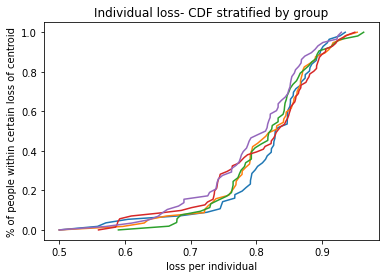

0.017746619543913877
total:  0.5358322519797447
weights:  [0.20169423 0.20067516 0.20113534 0.19983389 0.19666138]
Time elapsed Batch Step:  0.010936260223388672
Time elapsed Assignment Step:  0.015684127807617188
0.01764700365674754
total:  0.5331831269122842


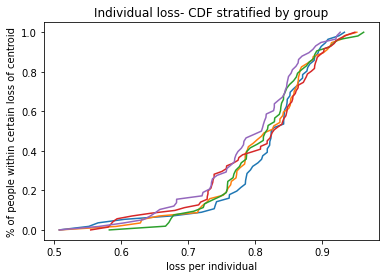

c  {0: (2.4177561767112326, -0.40531323677607445), 1: (-1.5454136640680523, 9.251803856751412), 2: (-2.7522753027973708, 2.985024186722235), 3: (2.104196152329071, 5.173023247784254)}
weights:  [0.20171264 0.2007133  0.20108127 0.19988714 0.19660565]
Time elapsed Batch Step:  0.016608476638793945
Time elapsed Assignment Step:  0.014997720718383789
0.0175247402663552
total:  0.530507953771447


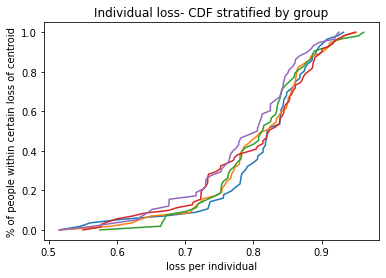

c  {0: (2.405061918652685, -0.37415150578455814), 1: (-1.5408521357994458, 9.220542794425768), 2: (-2.721271568257124, 2.9780241527819657), 3: (2.078500560756095, 5.154103609122704)}
weights:  [0.2017295  0.200751   0.20102455 0.19994383 0.19655111]
Time elapsed Batch Step:  0.009828805923461914
Time elapsed Assignment Step:  0.015798568725585938
0.017614270885486172
total:  0.5279649488153816


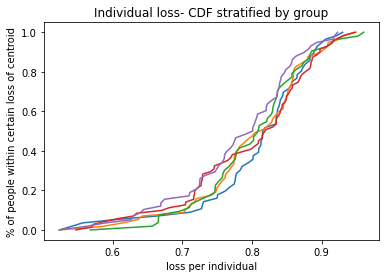

c  {0: (2.392331407258885, -0.34291349209856414), 1: (-1.5362630830478443, 9.189163718802629), 2: (-2.690707997355358, 2.971116186215043), 3: (2.0529858734592814, 5.135362971746659)}
weights:  [0.20174506 0.20078788 0.200965   0.20000411 0.19649796]
Time elapsed Batch Step:  0.012644529342651367
Time elapsed Assignment Step:  0.015059709548950195
0.01853613081966443
total:  0.5259636040401237


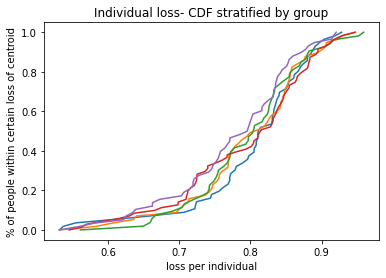

c  {0: (2.3795730082280118, -0.31162123310577683), 1: (-1.5316486052346816, 9.157682394771548), 2: (-2.660634986900477, 2.9642966159768207), 3: (2.0276917299378634, 5.116825644137633)}
weights:  [0.20175972 0.20082345 0.20090245 0.2000681  0.19644628]
Time elapsed Batch Step:  0.010117292404174805
Time elapsed Assignment Step:  0.02326679229736328
0.019560410876474865
total:  0.5240356364831376


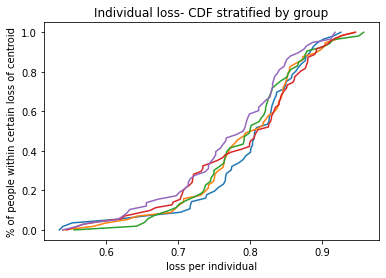

c  {0: (2.3667956751917734, -0.2802983990574467), 1: (-1.5270110490632618, 9.126115692891199), 2: (-2.6310968753978465, 2.957556917836711), 3: (2.0026590501098678, 5.09851259669092)}
weights:  [0.20177402 0.20085721 0.20083689 0.20013589 0.196396  ]
Time elapsed Batch Step:  0.012829303741455078
Time elapsed Assignment Step:  0.01703786849975586
0.02069220272066452
total:  0.5221901040724559


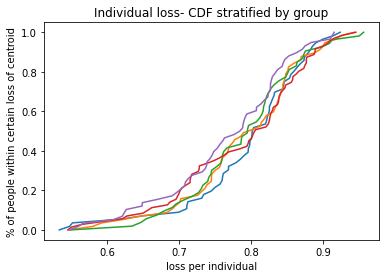

c  {0: (2.354008957711028, -0.248970334970248), 1: (-1.522353030599217, 9.09448160652661), 2: (-2.6021289058201904, 2.9508845898792444), 3: (1.9779278361295385, 5.080439027208692)}
weights:  [0.20178824 0.20088867 0.20076859 0.2002075  0.196347  ]
Time elapsed Batch Step:  0.010536432266235352
Time elapsed Assignment Step:  0.014793157577514648
0.021934587142729334
total:  0.5204335950543744


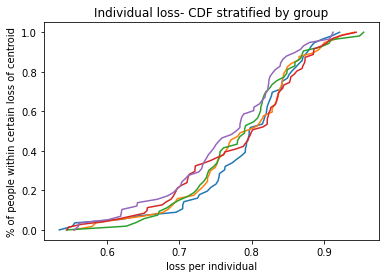

c  {0: (2.341223004974883, -0.21766409344983415), 1: (-1.517677458778862, 9.062799261746871), 2: (-2.5737554289343447, 2.9442653083581463), 3: (1.9535335822286013, 5.062612469050228)}
weights:  [0.20180219 0.20091764 0.20069779 0.2002831  0.19629928]
Time elapsed Batch Step:  0.00998544692993164
Time elapsed Assignment Step:  0.015140295028686523
0.023288337608666776
total:  0.518769625840329


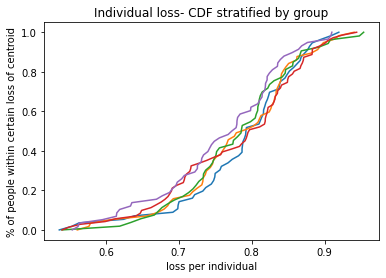

c  {0: (2.328448564496311, -0.18640845639261835), 1: (-1.5129875601963592, 9.031088918703148), 2: (-2.545990230353099, 2.9376856684232924), 3: (1.9295034271950289, 5.045033089635183)}
weights:  [0.20181504 0.20094428 0.20062422 0.20036329 0.19625318]
Time elapsed Batch Step:  0.010669231414794922
Time elapsed Assignment Step:  0.015876054763793945
0.024904487148038057
total:  0.5173012592488152


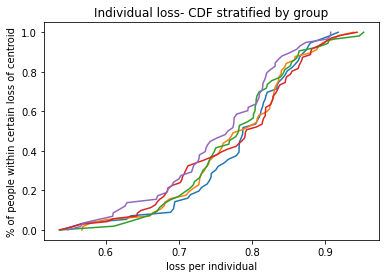

c  {0: (2.315696975077401, -0.15523394331026144), 1: (-1.5082869049178158, 8.999371963128239), 2: (-2.5188387958047525, 2.931135423165823), 3: (1.9058544294386588, 5.027696652198832)}
weights:  [0.20182447 0.20096799 0.20055124 0.20044801 0.19620829]
Time elapsed Batch Step:  0.009838342666625977
Time elapsed Assignment Step:  0.018161535263061523
0.02779038844934767
total:  0.51668652649329


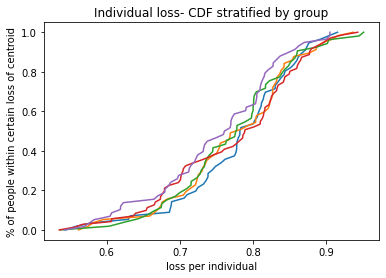

c  {0: (2.3029801533186953, -0.12417280382312017), 1: (-1.503579432940598, 8.967670886545859), 2: (-2.4923014255800053, 2.9246085782476827), 3: (1.8825950811299466, 5.010598297221087)}
weights:  [0.20182856 0.20098871 0.20048023 0.20053768 0.19616482]
Time elapsed Batch Step:  0.015360355377197266
Time elapsed Assignment Step:  0.017132282257080078
0.030241675097194887
total:  0.5158201492275539


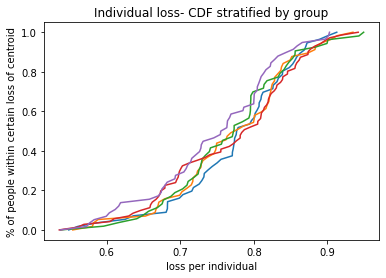

c  {0: (2.290310572976081, -0.09325899169776938), 1: (-1.498869480756942, 8.9360092537621), 2: (-2.466376098047124, 2.918103433931077), 3: (1.8597285910416645, 4.993735068351488)}
weights:  [0.20182583 0.20100662 0.20041201 0.20063222 0.19612332]
Time elapsed Batch Step:  0.010763406753540039
Time elapsed Assignment Step:  0.02335381507873535
0.031266788034766124
total:  0.5140577339548937


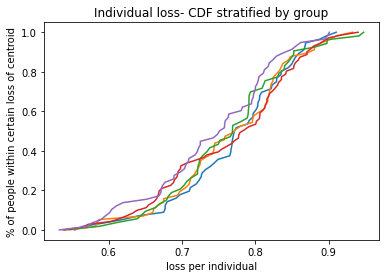

c  {0: (2.277701236531925, -0.06252811767609999), 1: (-1.4941618072918452, 8.904411656247055), 2: (-2.4410605415875084, 2.911622032198895), 3: (1.8372559476660746, 4.977106805497846)}
weights:  [0.20181582 0.20102266 0.20034709 0.20072916 0.19608527]
Time elapsed Batch Step:  0.010829687118530273
Time elapsed Assignment Step:  0.016124963760375977
0.032291708578054745
total:  0.5123301309024018


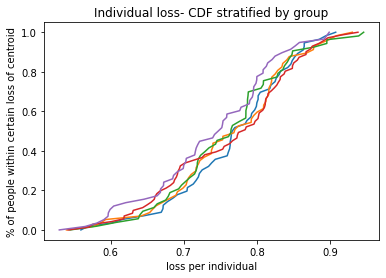

c  {0: (2.2651656384508434, -0.03201737827895956), 1: (-1.4894616182684703, 8.872903650117582), 2: (-2.4163534769831974, 2.9051694224414977), 3: (1.81517794908539, 4.960716062166687)}
weights:  [0.20179748 0.20103698 0.20028444 0.20082968 0.19605142]
Time elapsed Batch Step:  0.010596990585327148
Time elapsed Assignment Step:  0.02226567268371582
0.03209133348607707
total:  0.5098433900666445


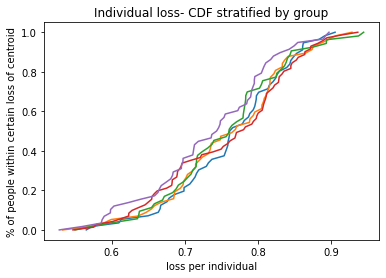

c  {0: (2.252717719739853, -0.001765457788027943), 1: (-1.4847745878161873, 8.841511677619708), 2: (-2.3922552129462864, 2.8987529766689883), 3: (1.7934962913388084, 4.944567660802871)}
weights:  [0.20177043 0.20105046 0.20022346 0.20093264 0.19602301]
Time elapsed Batch Step:  0.00985574722290039
Time elapsed Assignment Step:  0.016229867935180664
0.03110608038692908
total:  0.5068868549417516


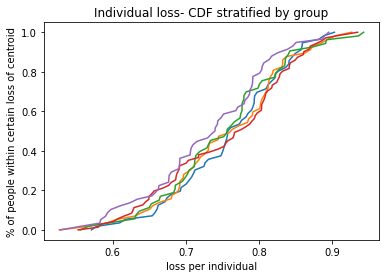

c  {0: (2.240371813630662, 0.02818759926056645), 1: (-1.4801068758885796, 8.810262971298458), 2: (-2.3687678006648416, 2.8923818397596714), 3: (1.7722140401465967, 4.928668189335106)}
weights:  [0.20173438 0.20106433 0.20016366 0.20103694 0.19600069]
Time elapsed Batch Step:  0.021345138549804688
Time elapsed Assignment Step:  0.018717050552368164
0.03187600421801384
total:  0.5051153895080128


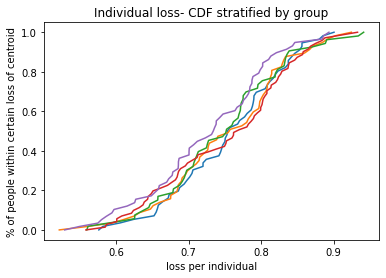

c  {0: (2.228142582448304, 0.05780054747469987), 1: (-1.4754651398195047, 8.779185440448437), 2: (-2.345894901754106, 2.8860665243508707), 3: (1.7513357507973377, 4.913025542163848)}
weights:  [0.20168895 0.20108057 0.20010474 0.20114156 0.19598419]
Time elapsed Batch Step:  0.01512765884399414
Time elapsed Assignment Step:  0.016208648681640625
0.03207334346895385
total:  0.5030206650393212


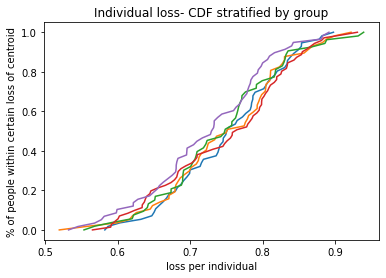

c  {0: (2.216044946020482, 0.08703113388374954), 1: (-1.4708565381402106, 8.748307539969419), 2: (-2.323641463411496, 2.879818630793283), 3: (1.7308674000241888, 4.897648524663079)}
weights:  [0.20163368 0.20110219 0.20004642 0.20124541 0.1959723 ]
Time elapsed Batch Step:  0.010697603225708008
Time elapsed Assignment Step:  0.015912532806396484
0.02989906699258571
total:  0.49943818998715295


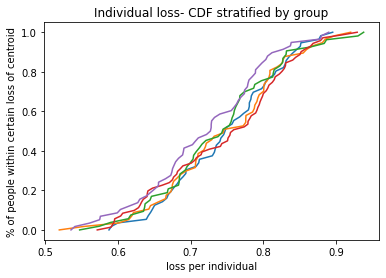

c  {0: (2.2040940023057014, 0.11583632649560766), 1: (-1.4662887246422855, 8.717658122406899), 2: (-2.3020132454880096, 2.873650664540718), 3: (1.7108162209803635, 4.882546513366459)}
weights:  [0.20156815 0.20113205 0.1999887  0.20134753 0.19596357]
Time elapsed Batch Step:  0.01101541519165039
Time elapsed Assignment Step:  0.015121221542358398
0.029472288798038204
total:  0.4970484928534675


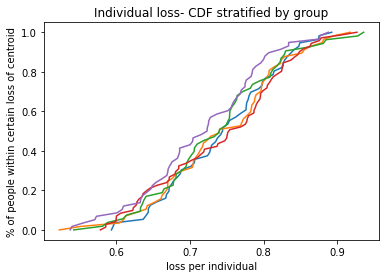

c  {0: (2.1923049412595503, 0.14417257877174933), 1: (-1.4617698306380185, 8.687266274723372), 2: (-2.2810162088367125, 2.8675759197204242), 3: (1.691190489578255, 4.8677291587496905)}
weights:  [0.20149262 0.20117011 0.19993236 0.20144762 0.19595728]
Time elapsed Batch Step:  0.011377573013305664
Time elapsed Assignment Step:  0.015978097915649414
0.03126438810908427
total:  0.4961596001576975


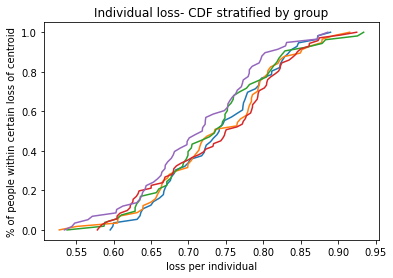

c  {0: (2.180692953296115, 0.17199612972985953), 1: (-1.4573084334814705, 8.65716114218926), 2: (-2.2606557526828452, 2.8616083880488046), 3: (1.6719992870079663, 4.853206118966372)}
weights:  [0.20140787 0.20121388 0.19987886 0.20154588 0.1959535 ]
Time elapsed Batch Step:  0.010354280471801758
Time elapsed Assignment Step:  0.014983415603637695
0.03398173773364932
total:  0.49593266236404077


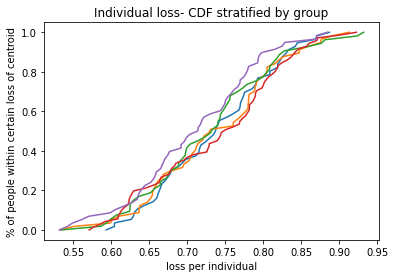

c  {0: (2.1692731340112017, 0.19926333831426501), 1: (-1.4529135097059274, 8.627371742648767), 2: (-2.2409357875986697, 2.8557626303126598), 3: (1.6532522507556984, 4.838986815807067)}
weights:  [0.20131461 0.20126088 0.19982965 0.20164238 0.19595247]
Time elapsed Batch Step:  0.010954856872558594
Time elapsed Assignment Step:  0.016258716583251953
0.037132839693555075
total:  0.4960508705098017
weights:  [0.20121333 0.20130939 0.19978587 0.20173693 0.19595449]
Time elapsed Batch Step:  0.011904716491699219
Time elapsed Assignment Step:  0.015830039978027344
0.04026168789626594
total:  0.49622056283842725
weights:  [0.20110446 0.20135814 0.1997481  0.20182927 0.19596003]
Time elapsed Batch Step:  0.010045051574707031
Time elapsed Assignment Step:  0.015374422073364258
0.04383804012884218
total:  0.49674939605004403
weights:  [0.20098857 0.20140621 0.19971619 0.20191921 0.19596982]
Time elapsed Batch Step:  0.012115240097045898
Time elapsed Assignment Step:  0.015817880630493164
0.04790

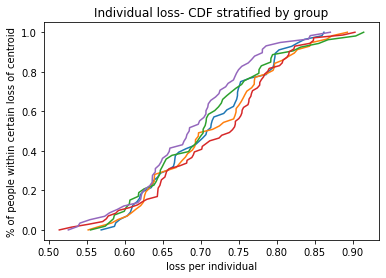

c  {0: (2.07746584209836, 0.41300182235340155), 1: (-1.417920541349963, 8.377961144744072), 2: (-2.091205268665918, 2.8106488033020645), 3: (1.506048516213329, 4.7258510253897565)}
weights:  [0.20019689 0.20166591 0.19960348 0.20241593 0.19611779]
Time elapsed Batch Step:  0.0101318359375
Time elapsed Assignment Step:  0.020721435546875
0.05309206278188272
total:  0.49214957602651677


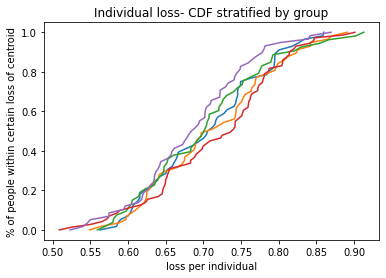

c  {0: (2.06871233945683, 0.43262076424248236), 1: (-1.4147071473894492, 8.352767756194012), 2: (-2.077361886061179, 2.80656997520597), 3: (1.4922098747190682, 4.714993333394013)}
weights:  [0.20005868 0.20170597 0.19959257 0.20249488 0.19614791]
Time elapsed Batch Step:  0.010999679565429688
Time elapsed Assignment Step:  0.01759028434753418
0.05116803157953442
total:  0.48965726283317973


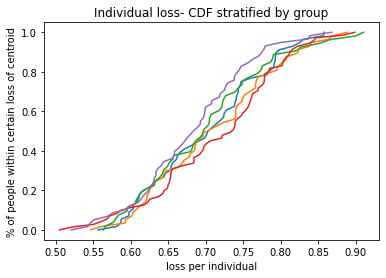

c  {0: (2.0602867232487303, 0.45132971853117987), 1: (-1.4116572505336902, 8.328151772214937), 2: (-2.064008308739587, 2.802672412198438), 3: (1.4788841523549838, 4.704475787252041)}
weights:  [0.19992058 0.20174532 0.19958247 0.20257488 0.19617675]
Time elapsed Batch Step:  0.014095544815063477
Time elapsed Assignment Step:  0.01591968536376953
0.04927548621424904
total:  0.48725884035616174


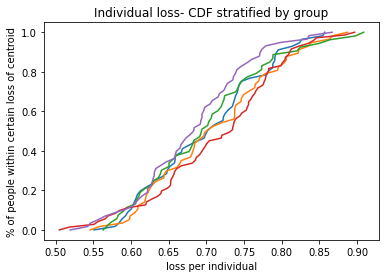

c  {0: (2.0521977510835874, 0.46912035935035645), 1: (-1.408776296556947, 8.304128721886768), 2: (-2.0511277542044164, 2.7989508190674086), 3: (1.4660682389791944, 4.694293942472477)}
weights:  [0.19978173 0.20178252 0.19957132 0.20266189 0.19620254]
Time elapsed Batch Step:  0.011324405670166016
Time elapsed Assignment Step:  0.015820026397705078
0.05067421029122765
total:  0.48707277330341836


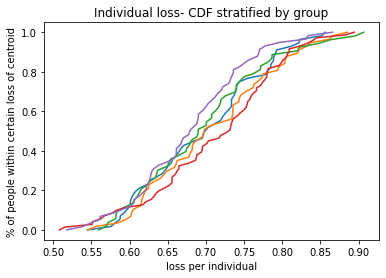

c  {0: (2.0444540469440233, 0.4859915984621645), 1: (-1.406068692224388, 8.28071256002966), 2: (-2.038704497760231, 2.7953996205664335), 3: (1.453757029363066, 4.684442568260449)}
weights:  [0.19964249 0.2018174  0.19955862 0.20275652 0.19622497]
Time elapsed Batch Step:  0.010154008865356445
Time elapsed Assignment Step:  0.016025066375732422
0.05017120958832766
total:  0.48571647975484594


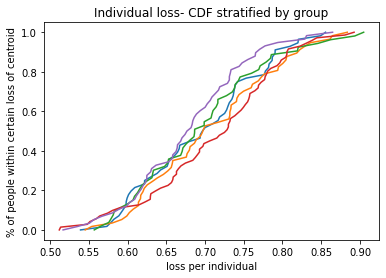

c  {0: (2.037064166134927, 0.5019519141390386), 1: (-1.403537745025799, 8.257915676111166), 2: (-2.026723769049442, 2.792013121823754), 3: (1.4419435653486214, 4.67491589374042)}
weights:  [0.19950485 0.20185134 0.19954559 0.20285271 0.1962455 ]
Time elapsed Batch Step:  0.01026296615600586
Time elapsed Assignment Step:  0.020091533660888672
0.04835888126960064
total:  0.48357208167564814


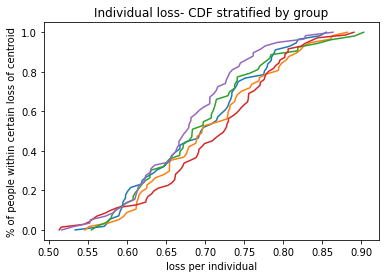

c  {0: (2.0300355312269316, 0.5170227758857163), 1: (-1.4011856219422472, 8.235748907810152), 2: (-2.0151716377655404, 2.788785609962663), 3: (1.430619235861519, 4.665707831685083)}
weights:  [0.19936954 0.20188445 0.19953233 0.20294921 0.19626447]
Time elapsed Batch Step:  0.010740280151367188
Time elapsed Assignment Step:  0.021826744079589844
0.046882902805430615
total:  0.48170654317171574


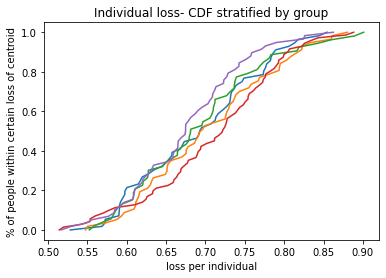

c  {0: (2.023371098692012, 0.5312410166845188), 1: (-1.3990133266242695, 8.214221555477526), 2: (-2.0040349024929007, 2.785711416489999), 3: (1.4197740086581558, 4.656812162464037)}
weights:  [0.19923708 0.20191663 0.19951884 0.20304544 0.19628202]
Time elapsed Batch Step:  0.010014533996582031
Time elapsed Assignment Step:  0.014601469039916992
0.04797647759004531
total:  0.4815681572053073


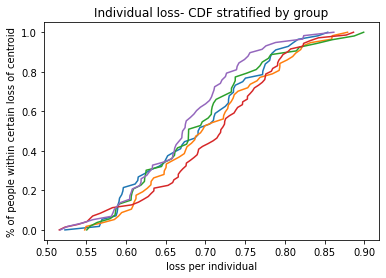

c  {0: (2.017065513638081, 0.5446558995630332), 1: (-1.3970206938168523, 8.193341394355723), 2: (-1.9933009892535847, 2.782784954241989), 3: (1.4093966671003921, 4.648222670295183)}
weights:  [0.19910799 0.20194779 0.19950524 0.20314064 0.19629833]
Time elapsed Batch Step:  0.010105371475219727
Time elapsed Assignment Step:  0.016292095184326172
0.04585304042417926
total:  0.4793923167061061


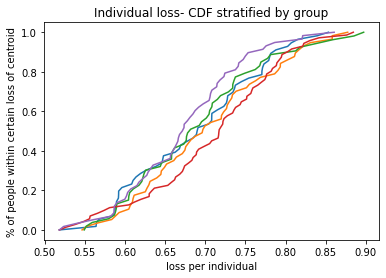

c  {0: (2.0111050247032236, 0.5573215551333116), 1: (-1.395206399540768, 8.173114682146732), 2: (-1.982957862298757, 2.780000738240219), 3: (1.399475029015373, 4.639933231883463)}
weights:  [0.19898275 0.20197787 0.1994917  0.20323413 0.19631356]
Time elapsed Batch Step:  0.009917736053466797
Time elapsed Assignment Step:  0.02294635772705078
0.04721773295803822
total:  0.4795343087640415
weights:  [0.19886172 0.20200672 0.19947834 0.20332544 0.19632779]
Time elapsed Batch Step:  0.010739564895629883
Time elapsed Assignment Step:  0.014813423156738281
0.04447963632424534
total:  0.47705734303562486


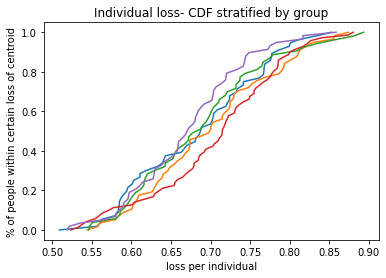

c  {0: (2.000142529538864, 0.5806120348273962), 1: (-1.3921018956600668, 8.134639047917231), 2: (-1.9633980681310694, 2.774837675868824), 3: (1.3809463632505992, 4.624230723404045)}
weights:  [0.1987453  0.20203417 0.19946519 0.20341424 0.1963411 ]
Time elapsed Batch Step:  0.011438608169555664
Time elapsed Assignment Step:  0.017781734466552734
0.04226630278948751
total:  0.4749672828373883


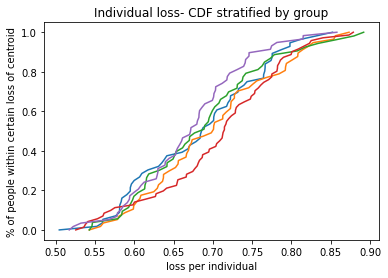

c  {0: (1.9950998298813072, 0.5913295977320566), 1: (-1.390803525311645, 8.116395028573505), 2: (-1.9541593906600494, 2.7724484423151328), 3: (1.3723115604124103, 4.616806098748297)}
weights:  [0.19863435 0.2020599  0.19945216 0.20350011 0.19635347]
Time elapsed Batch Step:  0.010042428970336914
Time elapsed Assignment Step:  0.02054762840270996
0.04075106503746917
total:  0.47337854055226397


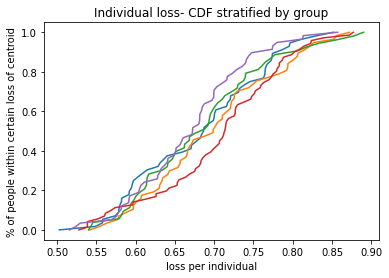

c  {0: (1.990323644055808, 0.6014832259423604), 1: (-1.3896672791306846, 8.098814229569863), 2: (-1.9452673814147443, 2.7701806825321067), 3: (1.3640770319070932, 4.609658330840403)}
weights:  [0.19853435 0.20208246 0.19943797 0.20358144 0.19636378]
Time elapsed Batch Step:  0.010380029678344727
Time elapsed Assignment Step:  0.015522003173828125
0.038159859176086885
total:  0.47114010027181485


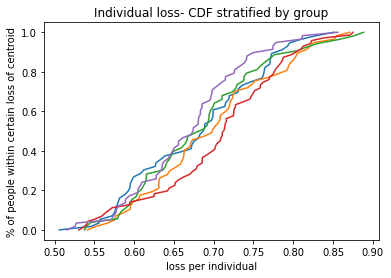

c  {0: (1.9857962746751074, 0.6111089795901382), 1: (-1.3886866406052387, 8.08189519560073), 2: (-1.9367117707282617, 2.7680295025777113), 3: (1.3562275647563342, 4.602781715287857)}
weights:  [0.19845105 0.20210031 0.19942127 0.20365656 0.19637081]
Time elapsed Batch Step:  0.010430574417114258
Time elapsed Assignment Step:  0.01464080810546875
0.03641829608428082
total:  0.4694937572862486


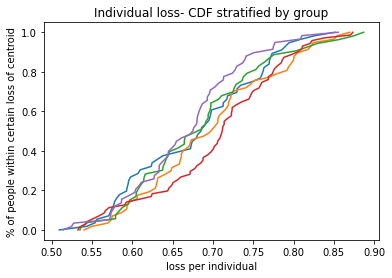

c  {0: (1.9815014758498424, 0.6202396488101474), 1: (-1.3878542516762318, 8.065634858168162), 2: (-1.9284825246495962, 2.7659901272676186), 3: (1.3487474234853452, 4.596170346500224)}
weights:  [0.19837461 0.20211588 0.19940456 0.2037278  0.19637715]
Time elapsed Batch Step:  0.011490106582641602
Time elapsed Assignment Step:  0.015334367752075195
0.03436058442057133
total:  0.4676776282366829


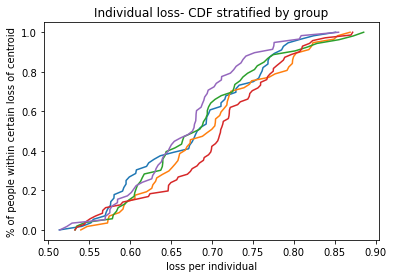

c  {0: (1.977424381006846, 0.6289051839403369), 1: (-1.38716200430664, 8.05002850380713), 2: (-1.9205698227099093, 2.7640578995677116), 3: (1.341620407712479, 4.589817931666253)}
weights:  [0.19830251 0.20212976 0.19938858 0.20379565 0.1963835 ]
Time elapsed Batch Step:  0.016320228576660156
Time elapsed Assignment Step:  0.01661539077758789
0.03252850418759745
total:  0.46604149104058157


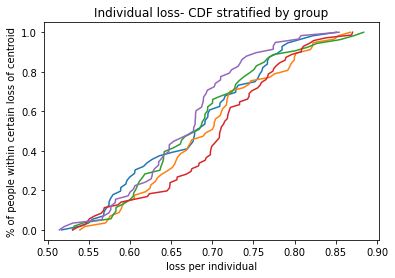

c  {0: (1.9735513897987234, 0.6371330585222416), 1: (-1.3866011457323435, 8.035069745330466), 2: (-1.912964040838574, 2.7622282802658216), 3: (1.3348300198895562, 4.583717625843553)}
weights:  [0.19823439 0.20214204 0.19937348 0.20386012 0.19638996]
Time elapsed Batch Step:  0.00992441177368164
Time elapsed Assignment Step:  0.015567302703857422
0.03153913242217621
total:  0.4649843207002399


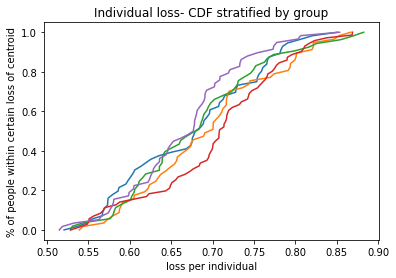

c  {0: (1.9698700456241882, 0.6449485726387665), 1: (-1.3861623994652459, 8.02075050202991), 2: (-1.9056557385775472, 2.7604968479488416), 3: (1.3283597450433968, 4.577861961432466)}
weights:  [0.19817013 0.20215276 0.19935939 0.20392123 0.19639648]
Time elapsed Batch Step:  0.009897708892822266
Time elapsed Assignment Step:  0.016089439392089844
0.0317126671717215
total:  0.46471223124347283


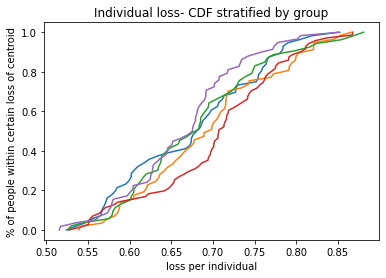

c  {0: (1.9663689174690555, 0.6523751065352349), 1: (-1.385836103556502, 8.007060996630806), 2: (-1.89863564985044, 2.7588592992509247), 3: (1.3221933745264636, 4.572242912068394)}
weights:  [0.19810967 0.20216195 0.19934639 0.203979   0.19640299]
Time elapsed Batch Step:  0.010217905044555664
Time elapsed Assignment Step:  0.01660299301147461
0.03245657327761953
total:  0.4648381543185831
weights:  [0.19805291 0.20216968 0.1993345  0.2040335  0.19640941]
Time elapsed Batch Step:  0.011000394821166992
Time elapsed Assignment Step:  0.015434741973876953
0.033496565796174216
total:  0.46518197489280805
weights:  [0.19799976 0.202176   0.19932372 0.20408482 0.19641571]
Time elapsed Batch Step:  0.01198887825012207
Time elapsed Assignment Step:  0.015491962432861328
0.03559343904064105
total:  0.4662364663313888
weights:  [0.19795007 0.20218098 0.19931398 0.20413306 0.1964219 ]
Time elapsed Batch Step:  0.009914159774780273
Time elapsed Assignment Step:  0.015461444854736328
0.035742923897

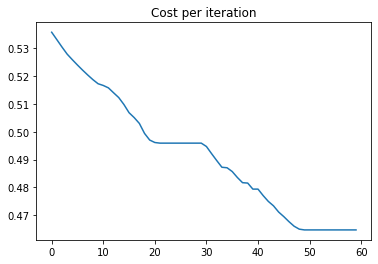

{0: (1.9663689174690555, 0.6523751065352349),
 1: (-1.385836103556502, 8.007060996630806),
 2: (-1.89863564985044, 2.7588592992509247),
 3: (1.3221933745264636, 4.572242912068394)}

In [70]:
df = assign_cluster(df, centroids)
groups = compute_groups(df)
compute_cdf_graph(groups)
clusters = compute_clusters(df)
cdf1, cdf2 = compute_cdf(groups)
#subgroup loss between max and min loss
subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)
loss = sum_loss(df, centroids, subgroup_loss)
update(centroids,df, subgroup_loss, loss, groups, cdf1, cdf2)

In [ ]:
df.head(30)

,x_coord,y_coord,group,dist_from_1,dist_from_2,dist_from_3,dist_from_4,dist_from_5,dist_from_6,dist_from_7,dist_from_8,dist_from_9,min_centr,min_loss
0,-1.404653,7.518255,3,9.275075,8.633056,17.487210,15.889283,5.934438,2.099212,8.976747,3.836994,4.599618,6,0.890827
1,-9.204275,6.972614,8,1.717545,16.451710,14.567370,22.198794,9.298707,8.099079,15.473868,11.231925,12.150193,1,0.847812
2,-1.203213,8.475455,3,9.489945,8.414280,18.417067,16.370764,6.900409,1.188132,9.503541,4.229943,4.032069,6,0.766407
3,-1.650650,3.173181,2,10.168490,10.160384,13.761751,13.745431,1.585568,6.440242,7.123070,4.373995,7.828482,5,0.829992
4,-8.527088,-8.955938,7,16.954784,23.243459,2.234819,20.320511,12.602891,19.836950,17.334708,17.980246,21.761405,3,0.903333
5,1.776019,0.790014,1,14.318027,9.149126,14.653786,9.656729,3.491752,9.427833,3.579859,4.869312,8.978713,5,0.970452
6,8.755960,-2.369553,4,21.958862,10.637579,19.719119,2.059397,11.108166,15.802978,5.221386,10.522864,13.560542,4,0.886894
7,-1.321891,7.579742,3,9.355720,8.546167,17.582210,15.865457,5.999472,2.045342,8.956737,3.795632,4.497516,6,0.885476
8,2.140578,0.354543,1,14.851437,9.299711,14.716299,9.164733,3.960844,9.965632,3.350324,5.305081,9.386277,7,0.966115
9,-1.439105,7.615197,3,9.237544,8.660840,17.553488,15.977935,6.030164,2.000343,9.067244,3.914754,4.584385,6,0.880833


In [ ]:
df = assign_cluster(df, centroids)
df

Time elapsed Assignment Step:  2.3564553260803223


,x_coord,y_coord,group,dist_from_1,dist_from_2,dist_from_3,dist_from_4,dist_from_5,dist_from_6,dist_from_7,dist_from_8,dist_from_9,min_centr,min_loss
0,-1.404653,7.518255,3,9.258398,8.610287,17.484669,15.866544,5.916372,2.075472,8.985870,3.834454,4.575889,6,0.888496
1,-9.204275,6.972614,8,1.694105,16.428954,14.575455,22.174215,9.292424,8.096009,15.478650,11.220712,12.129034,1,0.844763
2,-1.203213,8.475455,3,9.475211,8.392588,18.414921,16.348603,6.882244,1.164278,9.513540,4.232595,4.009915,6,0.762109
3,-1.650650,3.173181,2,10.145598,10.136225,13.755853,13.720806,1.567769,6.416855,7.126200,4.352027,7.804588,5,0.827465
4,-8.527088,-8.955938,7,16.934061,23.221146,2.212031,20.299662,12.620595,19.816677,17.326368,17.956865,21.737757,3,0.901325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,9.482244,-2.057438,4,22.441772,10.457710,20.484123,1.420381,11.689427,16.037227,5.514370,10.776936,13.627414,4,0.805398
799996,5.357845,0.613922,5,17.571402,7.748415,17.618957,6.323587,7.046374,11.321322,0.901901,6.077605,9.502734,7,0.711340
799997,1.284055,8.219555,6,11.947304,5.899265,19.548464,14.431530,7.222645,3.141093,7.806929,2.663585,1.996785,9,0.880459
799998,1.036550,4.332408,0,12.209643,7.232411,16.397806,11.982706,3.805697,5.855409,5.094466,1.585124,5.604611,8,0.829929
